In [91]:
import os
import logging
from io import StringIO
import ebooklib
from ebooklib import epub
from bs4 import BeautifulSoup
from pprint import pprint
import spacy
from spacy.lang.en import English
from spacy.pipeline import EntityRuler
from collections import Counter
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import numpy as np
import nltk
import re


import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)

SCRIPT_DIR = os.getcwd()

In [92]:
def ebook2text(filename):
    """
    Get all the chapter text of an EPUB file.
    """
    book = epub.read_epub(filename)
    text = StringIO()
    for i,item in enumerate(book.get_items_of_type(ebooklib.ITEM_DOCUMENT)):
        bs = BeautifulSoup(item.content)
        ## skip non-chapters
        if len(bs.text) < 3000:
            continue
        text.write(bs.text)
    return text.getvalue()


def segment_text(text: str, segment_size: int, separator: chr = ' '):
    """
    Partition or segment a text considering the separator character.
    A typical text should not be divided in the middle of a word but between words,
    i.e., considering spaces.
    """
    if not isinstance(segment_size, int) or segment_size < 1:
        raise ValueError("segment_size must be a number > 1!")
    if separator not in text:
        raise ValueError("Separator '%s' not in text!" % separator)

    i = 0
    while i < len(text):
        piece = text[i:i + segment_size]
        ## partition into (before, separator, after)
        before, _, after = piece.rpartition(separator)
        ## increase position by segment_size but reduce by the length of the rest
        i += segment_size - len(after)
        ## right strip any remaining separator
        yield before.rstrip(separator)
        

def read_file_lines(filename, lowercase=False):
    """
    Read a text file line-by-line into a list.
    Commented lines (starting with '#') are ignored.
    """
    filepath = filename
    if not os.path.isabs(filepath):
        filepath = os.path.abspath(os.path.join(SCRIPT_DIR, filename))
    logging.debug("filepath: %s", filepath)
    result = set()
    for line in open(filepath):
        line = line.strip()
        if line.startswith('#'):
            continue
        if lowercase:
            line = line.lower()
        if line:
            result.add(line)
    return result


def replace_space_underscore_fornames(text, ner_names):
    """
    Because of tokenization spaces need to be replaced.
    """
    for word in ner_names:
        ## https://stackoverflow.com/questions/4893506/fastest-python-method-for-search-and-replace-on-a-large-string
        reg = re.compile('(%s)' % word)
        repl = word.replace(' ', '_')
        ## TODO use stream for speed-up
        text = reg.sub(repl, text)
    return text


def names_to_rulepatterns(names):
    """
    Translate a list of names into Spacey NER EntityRuler patterns.
    """
    patterns = []
    for name in names:
        name = name.strip()
        if name:
            patterns.append({'label': 'PERSON', 'pattern': name})
    return patterns


def get_person_names(text, ner_names=[], stopwords=[]):
    """
    Using NLP find all PERSON named-entities in the given *text*.
    Additional NER rules can be given by *ner_names*.
    Names to ignore can be given by *stopwords*.
    """
    ## convert to lowercase
    stopwords_lower = [word.lower() for word in stopwords]
    
    ## load English tokenizer, tagger, parser, NER and word vectors
    ## python -m spacy download en_core_web_sm
    nlp = spacy.load("en_core_web_sm")

    ## additional names for NER
    if ner_names:
        ## spaces need to be replaced because of tokenization
        ner_names_sub = [word.replace(' ', '_') for word in ner_names]
        text = replace_space_underscore_fornames(text, ner_names)
        ## extra NER rules
        ruler = EntityRuler(nlp)
        patterns = names_to_rulepatterns(ner_names_sub)
        ruler.add_patterns(patterns)
        nlp.add_pipe(ruler, before='ner')
        

    ## segment the text because spacey.nlp accepts max. 100000 bytes only
    segment_size = 100000
    segments = segment_text(text, segment_size)
    
    ## find all person names which are not in the stoplist
    names = []
    for i,segment in enumerate(segments):
        logging.debug("NLP for book segment %d/%d...", i+1, len(text) / segment_size)
        doc = nlp(segment)
        names += [ent.text for ent in doc.ents if ent.label_ == 'PERSON' and ent.text.lower() not in stopwords_lower]
    
    return names

def get_most_common_items_inorder(items, top_n):
    """
    For a list of items return the top N most frequent retaining the original item-order.
    """
    ## top N most frequent items
    most_common = [item for item,_ in Counter(items).most_common(top_n)]
    ## list of the top N most frequent items but in the order they were seen
    items_chronologically = []
    for item in items:
        if item in most_common and item not in items_chronologically:
            items_chronologically.append(item)
        if len(items_chronologically) >= top_n:
            break
    return items_chronologically


In [93]:
ner_names = ('Moby Dick', 'huhu foo')
[word.replace(' ', '_') for word in ner_names]
text = "foo Moby Dick bar huhu foo"

for word in ner_names:
    ## https://stackoverflow.com/questions/4893506/fastest-python-method-for-search-and-replace-on-a-large-string
    reg = re.compile('(%s)' % word)
    repl = word.replace(' ', '_')
    text = reg.sub(repl, text)
text

'foo Moby_Dick bar huhu_foo'

In [94]:
nlp = English()
ruler = EntityRuler(nlp)
patterns = [{"label": "PERSON", "pattern": "Moby Dick"},
            {"label": "GPE", "pattern": "New York"}]
ruler.add_patterns(patterns)
nlp.add_pipe(ruler)

doc = nlp('last night i saw a black dog barking at a kid. My Moby Dick is not a Captain. Herkules is great. And Araminta is my girl. New York is a location.')
print([(ent.text, ent.label_) for ent in doc.ents])

[('Moby Dick', 'PERSON'), ('New York', 'GPE')]


In [95]:
# Load English tokenizer, tagger, parser, NER and word vectors
nlp = spacy.load("en_core_web_sm")

ruler = EntityRuler(nlp)
patterns = [{"label": "PERSON", "pattern": "Moby Dick"},
            {"label": "GPE", "pattern": "New York"}]
ruler.add_patterns(patterns)
nlp.add_pipe(ruler)

doc = nlp('last night i saw a black dog barking at a kid. My Moby Dick is not a Captain. Herkules is great. And Araminta is my girl. New York is a location.')
print([(ent.text, ent.label_) for ent in doc.ents])

[('last night', 'TIME'), ('Moby Dick', 'PERSON'), ('Araminta', 'PERSON'), ('New York', 'GPE')]


In [103]:
# Load English tokenizer, tagger, parser, NER and word vectors
nlp = spacy.load("en_core_web_sm")

ruler = EntityRuler(nlp)
patterns = names_to_rulepatterns("""
Moby Dick
Herkules
""".splitlines())
ruler.add_patterns(patterns)
nlp.add_pipe(ruler, before='ner')

doc = nlp('last night i saw a black dog barking at a kid. My Moby Dick is not a Captain. Herkules is great. And Araminta is my girl. New York is a location.')
print([(ent.text, ent.label_) for ent in doc.ents])

[('last night', 'TIME'), ('Moby Dick', 'PERSON'), ('Herkules', 'PERSON'), ('Araminta', 'PERSON'), ('New York', 'GPE')]


In [97]:
nlp.pipeline

[('tagger', <spacy.pipeline.pipes.Tagger at 0x7f945d0426d0>),
 ('parser', <spacy.pipeline.pipes.DependencyParser at 0x7f945e345400>),
 ('ner', <spacy.pipeline.pipes.EntityRecognizer at 0x7f945e3459a0>)]

In [100]:
text = ''
for i in range(999,1005):
    text += "%d " % i

print(text)
list(segment_text(text.strip(), 10))

999 1000 1001 1002 1003 1004 


['999 1000', '1001 1002', '1003', '']

In [99]:
list(segment_text(text, 10, '00'))

['999 1', ' 1001 1', '2 1003 1', '']

In [197]:
stopwords = read_file_lines('../stopwords.txt', lowercase=True)

{'aye',
 'cook',
 'living',
 'master',
 'mr.',
 'nay',
 'sir',
 'sperm',
 'sperm whale',
 'thou',
 'ye'}

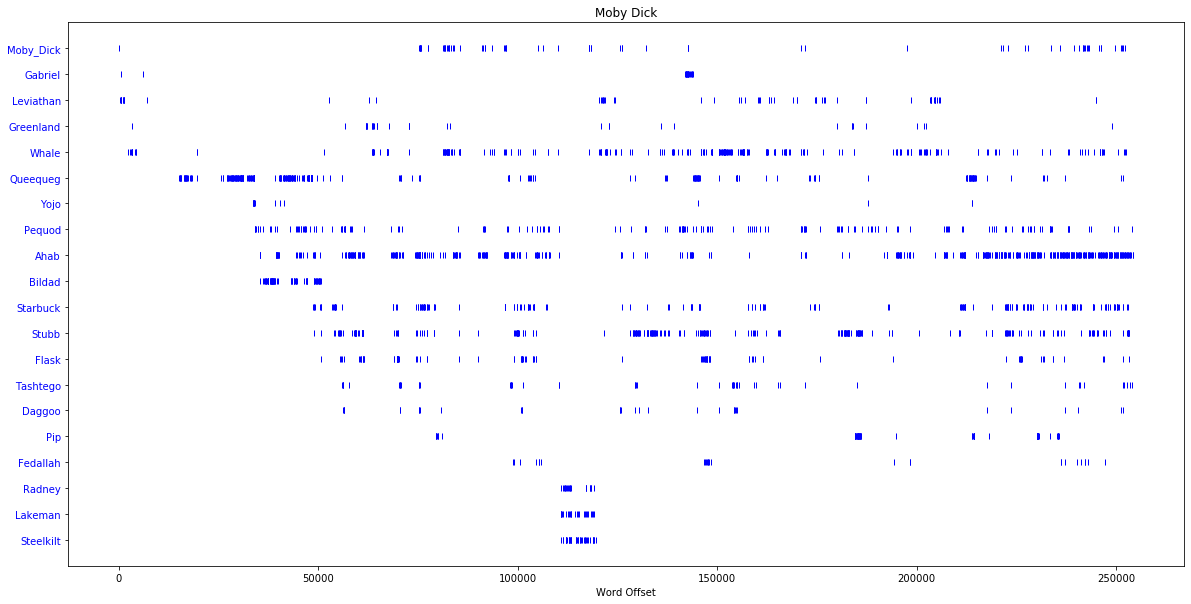

In [284]:
filename1 = "moby-dick.epub"
text1 = ebook2text(filename1)
ner_names1=('Moby Dick','Ahab')
text1 = replace_space_underscore_fornames(text1, ner_names1)
names1 = get_person_names(text1, ner_names=ner_names1, stopwords=stopwords)
mcn1 = get_most_common_items_inorder(names1, 20)
nltk.draw.dispersion_plot(nltk.word_tokenize(text1), mcn1, title="Moby Dick")

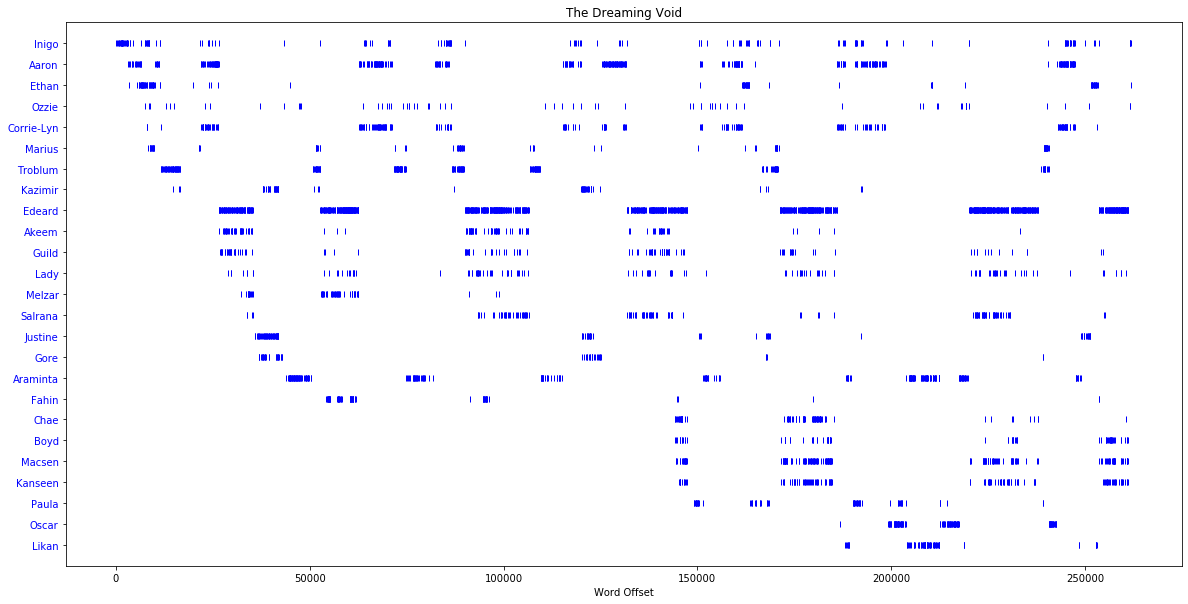

In [283]:
filename2 = "../HamiltonDreamingVoid/1 - Dreaming Void, The - Peter F. Hamilton.epub"
ner_names2 = read_file_lines('../HamiltonDreamingVoid/characters.txt')
text2 = ebook2text(filename)
text2 = replace_space_underscore_fornames(text2, ner_names2)
names2 = get_person_names(text2, ner_names=ner_names2, stopwords=stopwords)
mcn2 = get_most_common_items_inorder(names2, 25)
nltk.draw.dispersion_plot(nltk.word_tokenize(text2), mcn2, title="The Dreaming Void")